In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

### Read data

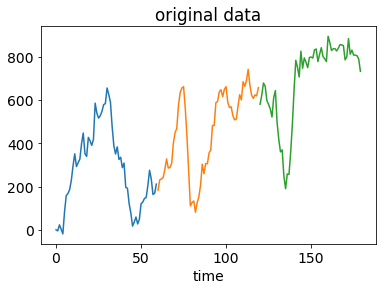

data:  10000


In [2]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

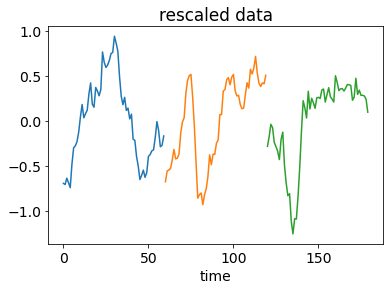

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [3]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [23]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

## from keras import regularizers, initializers

reg = tf.keras.regularizers.l2(0.2) ## raised to 0.2
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                        seed=None)
NCONV = 1
NF = 5

# challenge: at most 600 tunable parameters
model = Sequential()
# 
if NCONV==1:
    # -----2-----
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
# 
if NCONV==2:
    # -----1-----
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg, ######## TRY WITHOUT !
                     activation='relu', input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Flatten())
    model.add(Dense(9, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.3))
model.add(Dense(n_class, activation='softmax')) # softmax !

print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

----- Model 1 -----
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 50, 5)             60        
                                                                 
 average_pooling1d_3 (Averag  (None, 10, 5)            0         
 ePooling1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten_3 (Flatten)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 12)                252       
                                                                 
 dropout_4 (Dropout)         (None, 12)                0         
                                  

In [24]:
model.layers

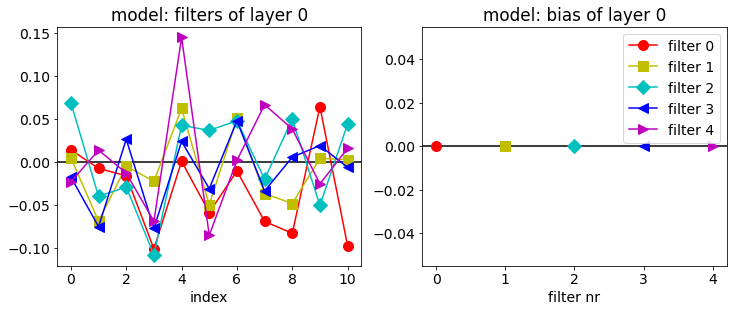

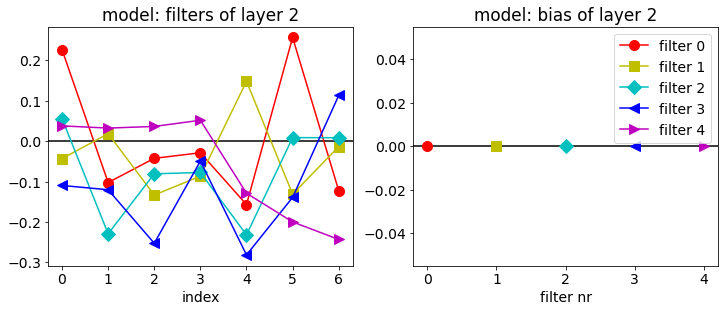

In [29]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [30]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 250
EPOCHS = 100

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 

----- Model  1 -----
FITTING....
Epoch 1/100
32/32 - 2s - loss: 1.1166 - accuracy: 0.3440 - val_loss: 1.1055 - val_accuracy: 0.3670 - 2s/epoch - 77ms/step
Epoch 2/100
32/32 - 0s - loss: 1.0984 - accuracy: 0.3943 - val_loss: 1.0893 - val_accuracy: 0.3910 - 194ms/epoch - 6ms/step
Epoch 3/100
32/32 - 0s - loss: 1.0744 - accuracy: 0.4755 - val_loss: 1.0572 - val_accuracy: 0.5305 - 201ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 1.0298 - accuracy: 0.5691 - val_loss: 0.9961 - val_accuracy: 0.6545 - 218ms/epoch - 7ms/step
Epoch 5/100
32/32 - 0s - loss: 0.9681 - accuracy: 0.6121 - val_loss: 0.9174 - val_accuracy: 0.6825 - 240ms/epoch - 7ms/step
Epoch 6/100
32/32 - 0s - loss: 0.8852 - accuracy: 0.6556 - val_loss: 0.8287 - val_accuracy: 0.7190 - 207ms/epoch - 6ms/step
Epoch 7/100
32/32 - 0s - loss: 0.8130 - accuracy: 0.6773 - val_loss: 0.7522 - val_accuracy: 0.7420 - 194ms/epoch - 6ms/step
Epoch 8/100
32/32 - 0s - loss: 0.7538 - accuracy: 0.7042 - val_loss: 0.6929 - val_accuracy: 0.7565 - 

Epoch 67/100
32/32 - 0s - loss: 0.1835 - accuracy: 0.9546 - val_loss: 0.1591 - val_accuracy: 0.9580 - 191ms/epoch - 6ms/step
Epoch 68/100
32/32 - 0s - loss: 0.1815 - accuracy: 0.9516 - val_loss: 0.1575 - val_accuracy: 0.9555 - 315ms/epoch - 10ms/step
Epoch 69/100
32/32 - 0s - loss: 0.1799 - accuracy: 0.9520 - val_loss: 0.1581 - val_accuracy: 0.9565 - 201ms/epoch - 6ms/step
Epoch 70/100
32/32 - 0s - loss: 0.1800 - accuracy: 0.9534 - val_loss: 0.1578 - val_accuracy: 0.9545 - 295ms/epoch - 9ms/step
Epoch 71/100
32/32 - 0s - loss: 0.1806 - accuracy: 0.9529 - val_loss: 0.1558 - val_accuracy: 0.9595 - 201ms/epoch - 6ms/step
Epoch 72/100
32/32 - 0s - loss: 0.1794 - accuracy: 0.9544 - val_loss: 0.1606 - val_accuracy: 0.9545 - 260ms/epoch - 8ms/step
Epoch 73/100
32/32 - 0s - loss: 0.1773 - accuracy: 0.9560 - val_loss: 0.1550 - val_accuracy: 0.9545 - 214ms/epoch - 7ms/step
Epoch 74/100
32/32 - 0s - loss: 0.1720 - accuracy: 0.9551 - val_loss: 0.1535 - val_accuracy: 0.9560 - 226ms/epoch - 7ms/step

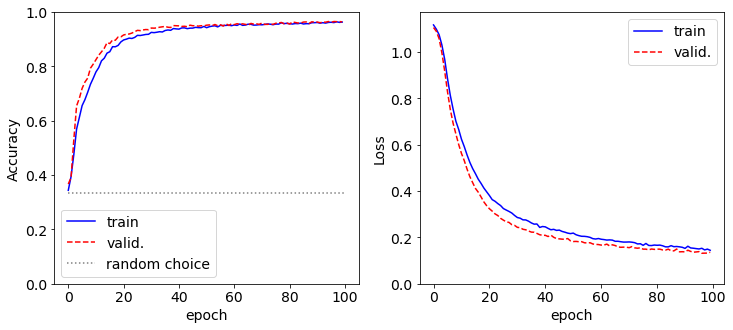

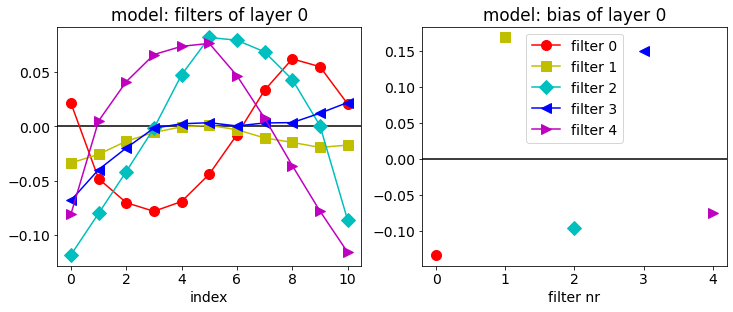

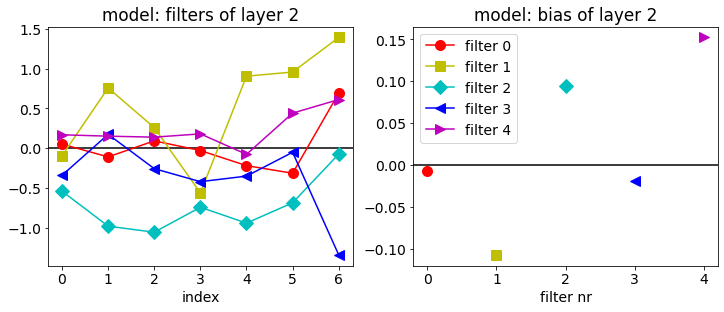

In [31]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

In [32]:
# ...LESSON ...
reg2 = tf.keras.regularizers.l1(0.5)
model2 = keras.models.clone_model(model)
model2.layers[0].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2 = 250
EPOCHS2 = 100

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,
                validation_data=(x_val, y_val), verbose=2, shuffle=True) 

Epoch 1/100
32/32 - 1s - loss: 1.0674 - accuracy: 0.4364 - val_loss: 0.9576 - val_accuracy: 0.6285 - 837ms/epoch - 26ms/step
Epoch 2/100
32/32 - 0s - loss: 0.8390 - accuracy: 0.6908 - val_loss: 0.7006 - val_accuracy: 0.7915 - 197ms/epoch - 6ms/step
Epoch 3/100
32/32 - 0s - loss: 0.6360 - accuracy: 0.7889 - val_loss: 0.5213 - val_accuracy: 0.8545 - 199ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 0.5070 - accuracy: 0.8503 - val_loss: 0.4290 - val_accuracy: 0.8870 - 196ms/epoch - 6ms/step
Epoch 5/100
32/32 - 0s - loss: 0.4230 - accuracy: 0.8829 - val_loss: 0.3532 - val_accuracy: 0.9075 - 192ms/epoch - 6ms/step
Epoch 6/100
32/32 - 0s - loss: 0.3714 - accuracy: 0.9050 - val_loss: 0.3057 - val_accuracy: 0.9250 - 191ms/epoch - 6ms/step
Epoch 7/100
32/32 - 0s - loss: 0.3262 - accuracy: 0.9170 - val_loss: 0.2787 - val_accuracy: 0.9340 - 210ms/epoch - 7ms/step
Epoch 8/100
32/32 - 0s - loss: 0.3028 - accuracy: 0.9268 - val_loss: 0.2553 - val_accuracy: 0.9385 - 214ms/epoch - 7ms/step
Epoch 9

Epoch 67/100
32/32 - 0s - loss: 0.0966 - accuracy: 0.9797 - val_loss: 0.0874 - val_accuracy: 0.9820 - 189ms/epoch - 6ms/step
Epoch 68/100
32/32 - 0s - loss: 0.0942 - accuracy: 0.9809 - val_loss: 0.0853 - val_accuracy: 0.9840 - 204ms/epoch - 6ms/step
Epoch 69/100
32/32 - 0s - loss: 0.0957 - accuracy: 0.9803 - val_loss: 0.0837 - val_accuracy: 0.9825 - 216ms/epoch - 7ms/step
Epoch 70/100
32/32 - 0s - loss: 0.0908 - accuracy: 0.9797 - val_loss: 0.0839 - val_accuracy: 0.9825 - 220ms/epoch - 7ms/step
Epoch 71/100
32/32 - 0s - loss: 0.0948 - accuracy: 0.9789 - val_loss: 0.0803 - val_accuracy: 0.9845 - 227ms/epoch - 7ms/step
Epoch 72/100
32/32 - 0s - loss: 0.0934 - accuracy: 0.9811 - val_loss: 0.0846 - val_accuracy: 0.9820 - 203ms/epoch - 6ms/step
Epoch 73/100
32/32 - 0s - loss: 0.0928 - accuracy: 0.9799 - val_loss: 0.0816 - val_accuracy: 0.9815 - 186ms/epoch - 6ms/step
Epoch 74/100
32/32 - 0s - loss: 0.0918 - accuracy: 0.9808 - val_loss: 0.0796 - val_accuracy: 0.9855 - 188ms/epoch - 6ms/step


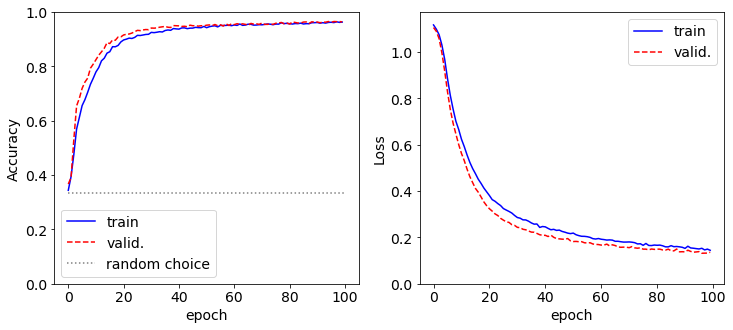

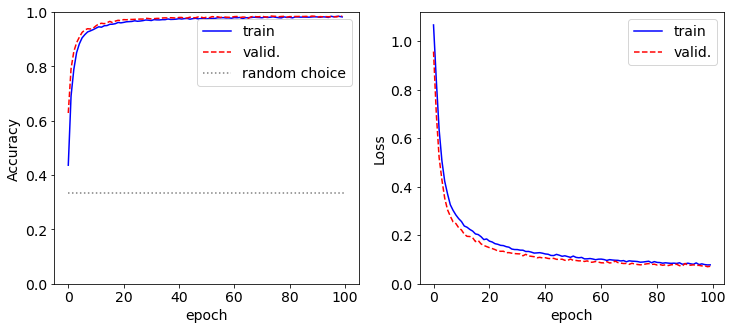

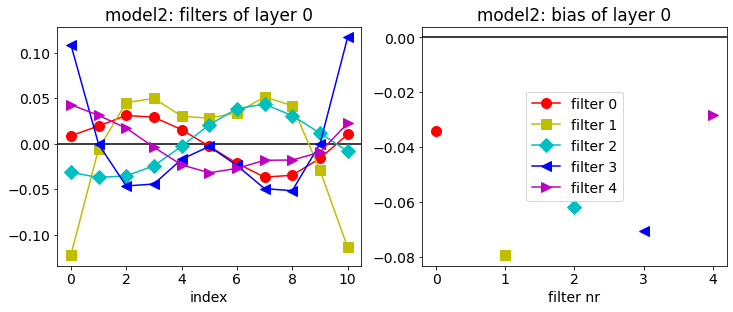

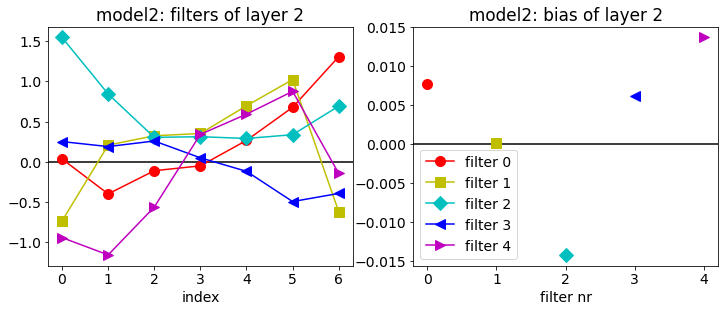

In [33]:
Show_history(fit)
Show_history(fit2)
Show_weights(model2,0,label="model2")
Show_weights(model2,2,label="model2")

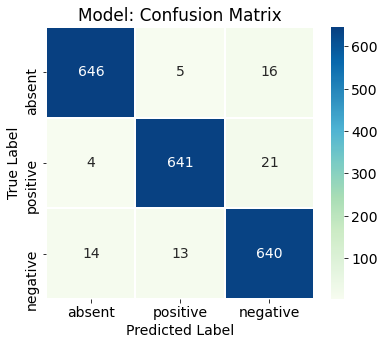

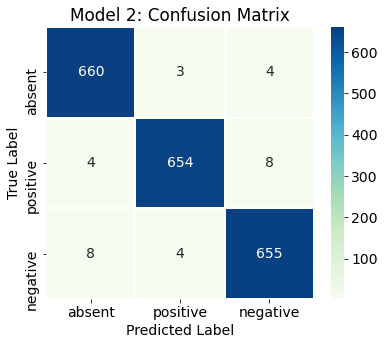

In [34]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2")

#print(classification_report(max_y_val, max_y_pred_val))